In [1]:
import datetime
import numpy as np
import tensorflow as tf
print(tf.__version__)
import tensorflow_addons as tfa

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

2.1.0


In [2]:
from model import *
from contrast_loss_utils import *

In [3]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# global configs
EPOCHS = 20
# DATA = 'mnist'
DATA = 'fashion_mnist'
NORMALIZE_EMBEDDING = True
N_DATA_TRAIN = 60000
BATCH_SIZE = 32
PROJECTION_DIM = 128
WRITE_SUMMARY = True

In [5]:
!mkdir -p logs/

In [6]:
optimizer = tf.keras.optimizers.Adam()

# Load MNIST data

In [7]:
if DATA == 'mnist':
    mnist = tf.keras.datasets.mnist
elif DATA == 'fashion_mnist':
    mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [8]:
# simulate low data regime for training
n_train = x_train.shape[0]
shuffle_idx = np.arange(n_train)
np.random.shuffle(shuffle_idx)

x_train = x_train[shuffle_idx][:N_DATA_TRAIN]
y_train = y_train[shuffle_idx][:N_DATA_TRAIN]
print(x_train.shape, y_train.shape)

(60000, 784) (60000,)


In [9]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(5000).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

# Train baseline model

In [10]:
mlp = MLP(normalize=NORMALIZE_EMBEDDING)

In [11]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [12]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [13]:
@tf.function
def train_step_baseline(x, y):
    with tf.GradientTape() as tape:
        y_preds = mlp(x, training=True)
        loss = cce_loss_obj(y, y_preds)

    gradients = tape.gradient(loss, 
                              mlp.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  mlp.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [14]:
@tf.function
def test_step_baseline(x, y):
    y_preds = mlp(x, training=False)
    t_loss = cce_loss_obj(y, y_preds)
    test_loss(t_loss)
    test_acc(y, y_preds)

In [15]:
model_name = 'baseline'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [16]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x, y in train_ds:
        train_step_baseline(x, y)
        
    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_acc.result(), step=epoch)        

    for x_te, y_te in test_ds:
        test_step_baseline(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_acc.result(), step=epoch)        

    template = 'Epoch {}, Loss: {}, Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 1.718235969543457, Acc: 80.79666137695312, Test Loss: 1.6371972560882568, Test Acc: 83.06999969482422
Epoch 2, Loss: 1.6172566413879395, Acc: 84.6816635131836, Test Loss: 1.6116398572921753, Test Acc: 85.15999603271484
Epoch 3, Loss: 1.6033663749694824, Acc: 85.91667175292969, Test Loss: 1.6140375137329102, Test Acc: 84.83999633789062
Epoch 4, Loss: 1.596086025238037, Acc: 86.56832885742188, Test Loss: 1.6077021360397339, Test Acc: 85.3499984741211
Epoch 5, Loss: 1.5915601253509521, Acc: 

# Stage 1: train encoder with contrastive loss

In [17]:
encoder = Encoder(normalize=NORMALIZE_EMBEDDING)

In [18]:
projector = Projector(PROJECTION_DIM, normalize=NORMALIZE_EMBEDDING)

In [19]:
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_bce = tf.keras.metrics.BinaryCrossentropy(name='train_contrast_BCE')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_bce = tf.keras.metrics.BinaryCrossentropy(name='test_contrast_BCE')

In [20]:
@tf.function
# train step for the contrast loss
def train_step_contrast(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:
        y_contrasts = get_contrast_batch_labels(y)
        
        r = encoder(x, training=True)
        z = projector(r, training=True)
        
        D = pdist_euclidean(z)
        d_vec = square_to_vec(D)        
        loss = tfa.losses.contrastive_loss(y_contrasts, d_vec)

    gradients = tape.gradient(loss, 
                              encoder.trainable_variables + projector.trainable_variables)
    optimizer.apply_gradients(zip(gradients, 
                                  encoder.trainable_variables + projector.trainable_variables))

    train_loss(loss)
    train_bce(y_contrasts, d_vec)

In [21]:
@tf.function
def test_step_contrast(x, y):
    r = encoder(x, training=False)
    z = projector(r, training=False)

    D = pdist_euclidean(z)
    d_vec = square_to_vec(D)
    y_contrasts = get_contrast_batch_labels(y)

    t_loss = tfa.losses.contrastive_loss(y_contrasts, d_vec)

    test_loss(t_loss)
    test_bce(y_contrasts, d_vec)

In [22]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_bce.reset_states()
    test_loss.reset_states()
    test_bce.reset_states()

    for x, y in train_ds:
        train_step_contrast(x, y)

    for x_te, y_te in test_ds:
        test_step_contrast(x_te, y_te)

    template = 'Epoch {}, Loss: {}, BCE: {}, Test Loss: {}, Test BCE: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_bce.result() * 100,
                        test_loss.result(),
                        test_bce.result() * 100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.04916287958621979, BCE: 1164.041259765625, Test Loss: 0.038355764001607895, Test BCE: 1184.16943359375
Epoch 2, Loss: 0.03518293797969818, BCE: 1192.297119140625, Test Loss: 0.03411290794610977, Test BCE: 1187.6309814453125
Epoch 3, Loss: 0.031979236751794815, BCE: 1202.275634765625, Test Loss: 0.034698352217674255, Test BCE: 1234.809326171875
Epoch 4, Loss: 0.030154919251799583, BCE: 1205.2738037109375, Test Loss: 0.03217827156186104, Test BCE: 1250.0609130859375
Epoch 5, Loss: 0.02846

In [23]:
x_tr_proj = projector(encoder(x_train))
x_tr_proj.shape

TensorShape([60000, 128])

In [24]:
x_te_proj = projector(encoder(x_test))
x_te_proj.shape

TensorShape([10000, 128])

In [25]:
# convert tensor to np.array
x_tr_proj = tf.make_ndarray(tf.make_tensor_proto(x_tr_proj))
x_te_proj = tf.make_ndarray(tf.make_tensor_proto(x_te_proj))
print(x_tr_proj.shape, x_te_proj.shape)

(60000, 128) (10000, 128)


In [26]:
x_test.shape

(10000, 784)

## Check learned embedding

In [27]:
from sklearn.decomposition import PCA

In [28]:
# do PCA for the projected data
pca = PCA(n_components=2)
pca.fit(x_tr_proj)
x_te_proj_pca = pca.transform(x_te_proj)
x_te_proj_pca.shape

(10000, 2)

In [29]:
# do PCA for original data
pca = PCA(n_components=2)
pca.fit(x_train)
x_te_pca = pca.transform(x_test)
x_te_pca.shape

(10000, 2)

In [30]:
x_te_proj_df = pd.DataFrame(x_te_proj[:, :2], columns=['Proj1', 'Proj2'])
x_te_proj_df['label'] = y_test
# x_te_proj_df.head()

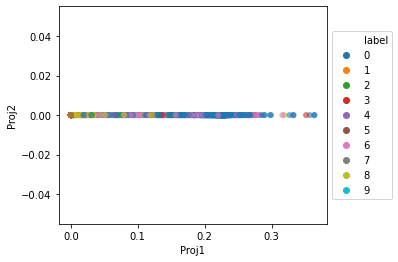

In [31]:
ax = sns.scatterplot('Proj1', 'Proj2', data=x_te_proj_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

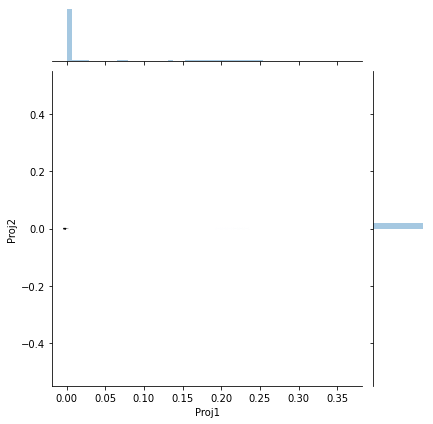

In [32]:
sns.jointplot('Proj1', 'Proj2', data=x_te_proj_df,
              kind="hex"
             );

In [33]:
x_te_proj_pca_df = pd.DataFrame(x_te_proj_pca, columns=['PC1', 'PC2'])
x_te_proj_pca_df['label'] = y_test

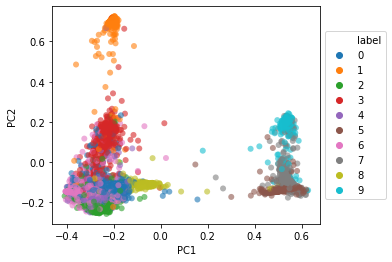

In [34]:
ax = sns.scatterplot('PC1', 'PC2', data=x_te_proj_pca_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               );

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

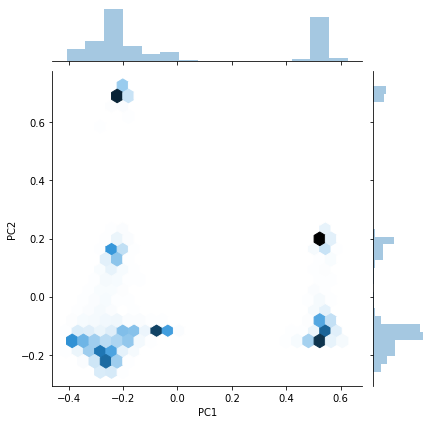

In [35]:
sns.jointplot('PC1', 'PC2', data=x_te_proj_pca_df,
              kind="hex"
             )

In [36]:
x_te_pca_df = pd.DataFrame(x_te_pca, columns=['PC1', 'PC2'])
x_te_pca_df['label'] = y_test

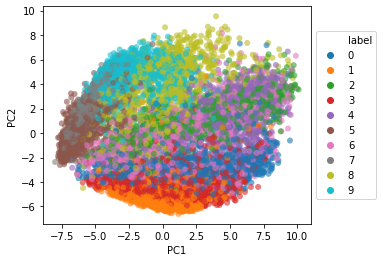

In [37]:
ax = sns.scatterplot('PC1', 'PC2', data=x_te_pca_df,
                palette='tab10',
                hue='label',
                linewidth=0,
                alpha=0.6
               )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

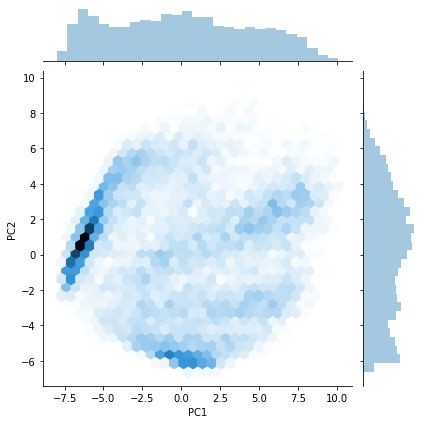

In [38]:
sns.jointplot('PC1', 'PC2', data=x_te_pca_df,
              kind="hex"
             );

# Stage 2: freeze the learned representations and then learn a classifier on a linear layer using a softmax loss

In [39]:
softmax = SoftmaxPred()

In [40]:
# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_ACC')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_ACC')

In [41]:
cce_loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [42]:
@tf.function
# train step for the 2nd stage
def train_step(x, y):
    '''
    x: data tensor, shape: (batch_size, data_dim)
    y: data labels, shape: (batch_size, )
    '''
    with tf.GradientTape() as tape:        
        r = encoder(x, training=False)
        y_preds = softmax(r, training=True)
        loss = cce_loss_obj(y, y_preds)

    # freeze the encoder, only train the softmax layer
    gradients = tape.gradient(loss, 
                              softmax.trainable_variables) 
    optimizer.apply_gradients(zip(gradients, 
                                  softmax.trainable_variables))

    train_loss(loss)
    train_acc(y, y_preds)

In [43]:
@tf.function
def test_step(x, y):
    r = encoder(x, training=False)
    y_preds = softmax(r, training=False)

    t_loss = cce_loss_obj(y, y_preds)

    test_loss(t_loss)
    test_acc(y, y_preds)

In [44]:
model_name = 'contrast_loss_model'
if WRITE_SUMMARY:
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = 'logs/%s/%s/%s/train' % (model_name, DATA, current_time)
    test_log_dir = 'logs/%s/%s/%s/test' % (model_name, DATA, current_time)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [45]:
for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for x, y in train_ds:
        train_step(x, y)

    if WRITE_SUMMARY:
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', train_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', train_acc.result(), step=epoch)        
        
    for x_te, y_te in test_ds:
        test_step(x_te, y_te)

    if WRITE_SUMMARY:
        with test_summary_writer.as_default():
            tf.summary.scalar('loss', test_loss.result(), step=epoch)
            tf.summary.scalar('accuracy', test_acc.result(), step=epoch)        
        
    template = 'Epoch {}, Loss: {}, Acc: {}, Test Loss: {}, Test Acc: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_acc.result() * 100,
                        test_loss.result(),
                        test_acc.result() * 100))

Epoch 1, Loss: 1.6179100275039673, Acc: 91.67333221435547, Test Loss: 1.5912376642227173, Test Acc: 88.68000030517578
Epoch 2, Loss: 1.5507826805114746, Acc: 92.70500183105469, Test Loss: 1.581690788269043, Test Acc: 88.9000015258789
Epoch 3, Loss: 1.5433152914047241, Acc: 92.89500427246094, Test Loss: 1.577972650527954, Test Acc: 89.02000427246094
Epoch 4, Loss: 1.5397268533706665, Acc: 93.01000213623047, Test Loss: 1.575952172279358, Test Acc: 89.02000427246094
Epoch 5, Loss: 1.5375289916992188, Acc: 93.08333587646484, Test Loss: 1.574662446975708, Test Acc: 89.02000427246094
Epoch 6, Loss: 1.5360137224197388, Acc: 93.16166687011719, Test Loss: 1.5737446546554565, Test Acc: 89.06000518798828
Epoch 7, Loss: 1.534874439239502, Acc: 93.1883316040039, Test Loss: 1.5730743408203125, Test Acc: 89.06000518798828
Epoch 8, Loss: 1.5339617729187012, Acc: 93.22833251953125, Test Loss: 1.572528600692749, Test Acc: 89.06999969482422
Epoch 9, Loss: 1.5332090854644775, Acc: 93.27166748046875, Test 

In [46]:
test_acc.result().numpy()

0.8931